In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
import joblib
import tkinter as tk
from tkinter import messagebox

In [2]:
# Load Dataset
df = pd.read_csv('961.csv')

In [3]:
df.head()

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
0,2767052-the-hunger-games,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...","['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",...,NaN,['Locus Award Nominee for Best Young Adult Boo...,6376780,"['3444695', '1921313', '745221', '171994', '93...",96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...,2993816,30516,5.09
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,Harry Potter #5,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...","['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",...,06/21/03,['Bram Stoker Award for Works for Young Reader...,2507623,"['1593642', '637516', '222366', '39573', '14526']",98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,2632233,26923,7.38
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,The unforgettable novel of a childhood in a sl...,English,9999999999999,"['Classics', 'Fiction', 'Historical Fiction', ...","['Scout Finch', 'Atticus Finch', 'Jem Finch', ...",...,07/11/60,"['Pulitzer Prize for Fiction (1961)', 'Audie A...",4501075,"['2363896', '1333153', '573280', '149952', '80...",95.0,"['Maycomb, Alabama (United States)']",https://i.gr-assets.com/images/S/compressed.ph...,2269402,23328,NaN
3,1885.Pride_and_Prejudice,Pride and Prejudice,NaN,"Jane Austen, Anna Quindlen (Introduction)",4.26,Alternate cover edition of ISBN 9780679783268S...,English,9999999999999,"['Classics', 'Fiction', 'Romance', 'Historical...","['Mr. Bennet', 'Mrs. Bennet', 'Jane Bennet', '...",...,01/28/13,[],2998241,"['1617567', '816659', '373311', '113934', '767...",94.0,"['United Kingdom', 'Derbyshire, England (Unite...",https://i.gr-assets.com/images/S/compressed.ph...,1983116,20452,NaN
4,41865.Twilight,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9780316015844,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...","['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",...,10/05/05,"['Georgia Peach Book Award (2007)', 'Buxtehude...",4964519,"['1751460', '1113682', '1008686', '542017', '5...",78.0,"['Forks, Washington (United States)', 'Phoenix...",https://i.gr-assets.com/images/S/compressed.ph...,1459448,14874,2.1


In [4]:
df = df[['bookId', 'title', 'author', 'rating', 'description', 'language', 'isbn', 'genres', 'pages', 'publisher', 'publishDate', 'numRatings', 'price']]

In [5]:
df.shape

(52478, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52478 entries, 0 to 52477
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bookId       52478 non-null  object 
 1   title        52478 non-null  object 
 2   author       52478 non-null  object 
 3   rating       52478 non-null  float64
 4   description  51140 non-null  object 
 5   language     48672 non-null  object 
 6   isbn         52478 non-null  object 
 7   genres       52478 non-null  object 
 8   pages        50131 non-null  object 
 9   publisher    48782 non-null  object 
 10  publishDate  51598 non-null  object 
 11  numRatings   52478 non-null  int64  
 12  price        38113 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [7]:
df['bookId'] = df['bookId'].astype(str).str.extract(r'^(\d+)')[0].astype(int)


In [8]:
import ast
import numpy as np

def extract_first_genre(val):
    try:
        genres_list = ast.literal_eval(val) if isinstance(val, str) else val
        return genres_list[0] if genres_list else np.nan
    except:
        return np.nan

df['genre'] = df['genres'].apply(extract_first_genre)


In [9]:
df['genre'].value_counts()

genre
Fiction                   6141
Fantasy                   5556
Romance                   3338
Young Adult               3145
Nonfiction                2564
                          ... 
Nobel Prize                  1
Asexual                      1
Love Inspired Suspense       1
Semiotics                    1
Sex Work                     1
Name: count, Length: 401, dtype: int64

In [10]:
df['language'].value_counts()

language
English                                  42661
Arabic                                    1038
Spanish                                    687
French                                     579
German                                     528
                                         ...  
Aromanian; Arumanian; Macedo-Romanian        1
Basque                                       1
Faroese                                      1
Iranian (Other)                              1
Norwegian Nynorsk; Nynorsk, Norwegian        1
Name: count, Length: 81, dtype: int64

In [11]:
df = df[df['language'] == 'English']


In [12]:
df = df[df['description'].notna()]
# df = df[df['description'].str.strip() != ''

In [13]:
df = df[df['genre'].notna()]


In [14]:
df.isnull().sum()

bookId            0
title             0
author            0
rating            0
description       0
language          0
isbn              0
genres            0
pages           915
publisher      1935
publishDate     273
numRatings        0
price          7417
genre             0
dtype: int64

In [15]:
df.duplicated().sum()


24

In [16]:
df = df.drop_duplicates()

In [17]:
df.shape

(39545, 14)

In [18]:
# Step 1: Get top 8 genres with counts
top_7_genres_counts = df['genre'].value_counts().nlargest(7)

# Step 2: Filter the DataFrame to include only those top 8 genres
df = df[df['genre'].isin(top_7_genres_counts.index)].reset_index(drop=True)

# Step 3: Display the counts
print(top_7_genres_counts)


genre
Fiction               4987
Fantasy               4854
Young Adult           2891
Romance               2824
Nonfiction            2118
Historical Fiction    1952
Mystery               1816
Name: count, dtype: int64


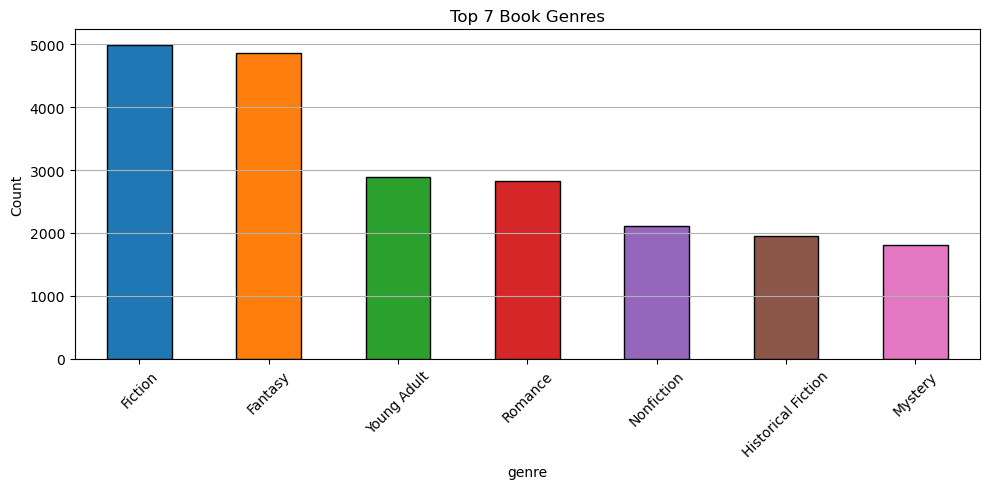

In [19]:
top_7 = df['genre'].value_counts().nlargest(7)
top_7.plot(kind='bar', figsize=(10, 5), color=plt.cm.tab10.colors, edgecolor='black')
plt.title('Top 7 Book Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21442 entries, 0 to 21441
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bookId       21442 non-null  int32  
 1   title        21442 non-null  object 
 2   author       21442 non-null  object 
 3   rating       21442 non-null  float64
 4   description  21442 non-null  object 
 5   language     21442 non-null  object 
 6   isbn         21442 non-null  object 
 7   genres       21442 non-null  object 
 8   pages        20985 non-null  object 
 9   publisher    20451 non-null  object 
 10  publishDate  21326 non-null  object 
 11  numRatings   21442 non-null  int64  
 12  price        17587 non-null  object 
 13  genre        21442 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(11)
memory usage: 2.2+ MB


In [46]:
df.head()

,bookId,title,author,rating,description,language,isbn,genres,pages,publisher,publishDate,numRatings,price,genre,word_count,Processed_Description
0,2767052,The Hunger Games,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",374,Scholastic Press,09/14/08,6376780,5.09,Young Adult,147,winning mean fame mean certain hunger game beg...
1,2,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",870,Scholastic Inc.,09/28/04,2507623,7.38,Fantasy,136,door end silent corridor haunting harry pottte...
2,41865,Twilight,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9780316015844,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...",501,"Little, Brown and Company",09/06/06,4964519,2.1,Young Adult,55,absolutely positive edward vampire second part...
3,19063,The Book Thief,Markus Zusak (Goodreads Author),4.37,Librarian's note: An alternate cover edition c...,English,9780375831003,"['Historical Fiction', 'Fiction', 'Young Adult...",552,Alfred A. Knopf,03/14/06,1834276,3.8,Historical Fiction,163,librarian alternate found hereit nazi germany ...
4,11127,The Chronicles of Narnia,"C.S. Lewis, Pauline Baynes (Illustrator)",4.26,"Journeys to the end of the world, fantastic cr...",English,9999999999999,"['Fantasy', 'Classics', 'Fiction', 'Young Adul...",767,HarperCollins,09/16/02,517740,NaN,Fantasy,178,journey end fantastic creature epic battle goo...


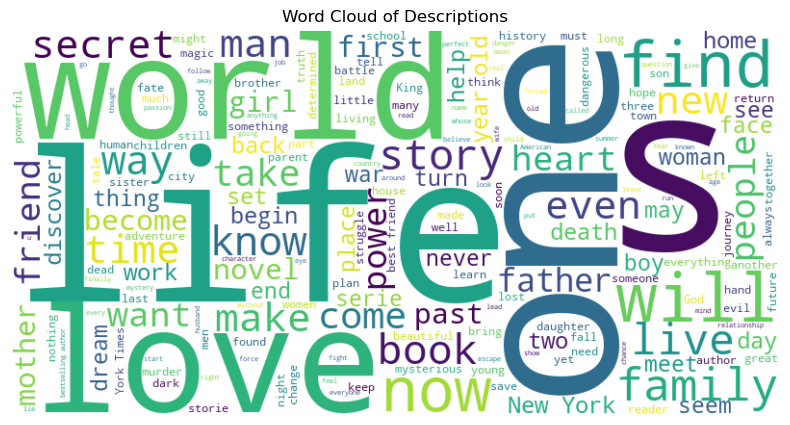

In [21]:
df['word_count'] = df['description'].apply(lambda x: len(str(x).split()))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['description'].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Descriptions')
plt.show()

In [22]:
stop_words = set(stopwords.words('english'))
# Define custom stopwords
custom_stopwords = {
    'reader', 'note', 'cover', 'original', 'series', 'dickens', 'shakespeare', 'betsy',
    'london', 'paris', 'victorian', 'century', 'christmas', 'white', 'would', 'every',
    'back', 'men', 'make', 'go', 'get', 'edition', 'introduction', 'english', 'text',
    'three', 'published', 'full', 'historical', 'family', 'work', 'friend', 'war', 'like',
    'tell', 'woman', 'whose', 'love', 'young', 'mother', 'father', 'must', 'world', 'man',
    'novel', 'year', 'life', 'one', 'story', 'new', 'time', 'book', 'first', 'find', 'two',
    'author', 'come', 'even', 'american', 'take', 'set', 'day', 'also', 'secret', 'know',
    'way', 'want', 'thing', 'truth', 'past', 'best', 'help', 'home', 'school', 'city',
    'place', 'people', 'always', 'might', 'seem', 'everything', 'live', 'old', 'dream',
    'volume', 'chapter'
}


In [23]:
def preprocess_text(text, custom_stopwords):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(str(text).lower())  # Convert to lowercase and tokenize
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]  # Lemmatization and stopword removal
    words = [word for word in words if word not in custom_stopwords]  # Apply custom stopwords
    return ' '.join(words)

In [24]:
# Apply text preprocessing
df['Processed_Description'] = df['description'].dropna().apply(lambda x: preprocess_text(x, custom_stopwords))

In [25]:
# TF-IDF Feature Extraction
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3))
X = vectorizer.fit_transform(df['Processed_Description']).toarray()
y = df['genre']

In [26]:
# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [28]:
# Train and evaluate models
def train_models(X_train, y_train, X_test, y_test):
    models = {
        "Naïve Bayes": MultinomialNB(alpha=0.5),
        "Decision Tree": DecisionTreeClassifier(max_depth=10),
        "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10)
    }
    accuracies = {}
    conf_matrices = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracies[name] = accuracy_score(y_test, y_pred)
        conf_matrices[name] = confusion_matrix(y_test, y_pred)
        
        print(f"\n {name} Accuracy: {accuracies[name]:.4f}")
        print(classification_report(y_test, y_pred))
    
    return models, accuracies, conf_matrices

models, accuracies, conf_matrices = train_models(X_train, y_train, X_test, y_test)


 Naïve Bayes Accuracy: 0.8074
                    precision    recall  f1-score   support

           Fantasy       0.83      0.80      0.81       997
           Fiction       0.73      0.61      0.67       997
Historical Fiction       0.79      0.84      0.82       997
           Mystery       0.88      0.91      0.89       998
        Nonfiction       0.86      0.89      0.88       998
           Romance       0.81      0.82      0.81       997
       Young Adult       0.74      0.79      0.76       998

          accuracy                           0.81      6982
         macro avg       0.81      0.81      0.81      6982
      weighted avg       0.81      0.81      0.81      6982


 Decision Tree Accuracy: 0.3691
                    precision    recall  f1-score   support

           Fantasy       0.68      0.27      0.39       997
           Fiction       0.19      0.75      0.31       997
Historical Fiction       0.64      0.23      0.34       997
           Mystery       0.68   

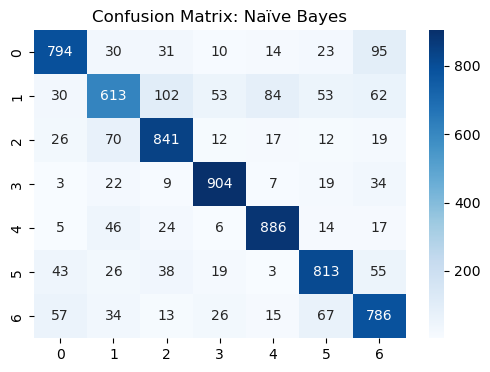

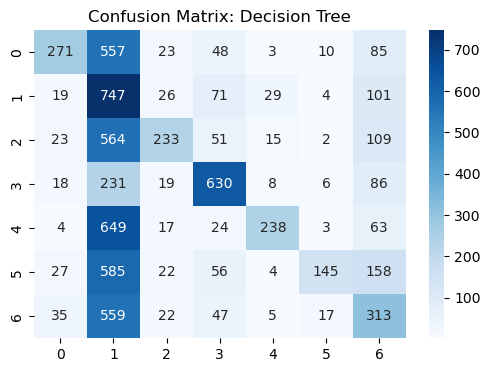

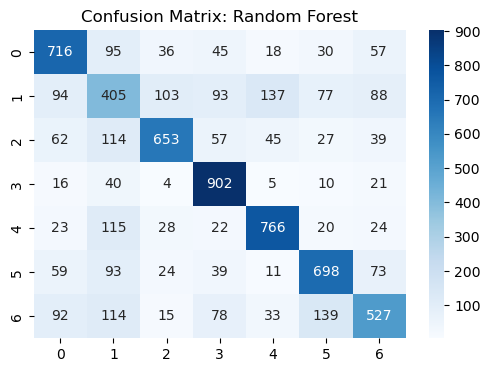

In [29]:
for name, matrix in conf_matrices.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

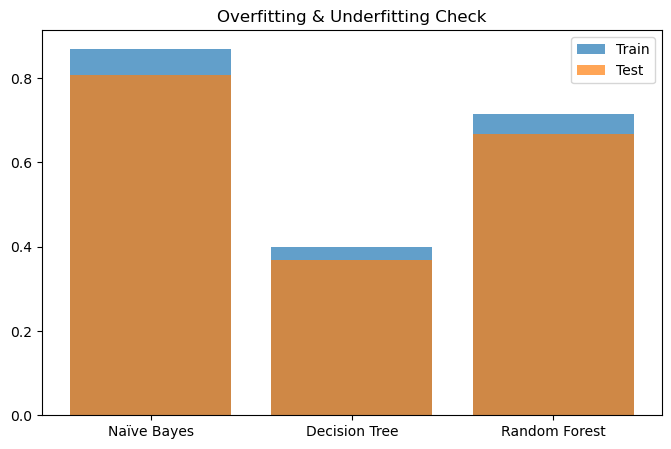

In [30]:
train_accuracies = {name: model.score(X_train, y_train) for name, model in models.items()}
plt.figure(figsize=(8, 5))
plt.bar(train_accuracies.keys(), train_accuracies.values(), alpha=0.7, label='Train')
plt.bar(accuracies.keys(), accuracies.values(), alpha=0.7, label='Test')
plt.title('Overfitting & Underfitting Check')
plt.legend()
plt.show()

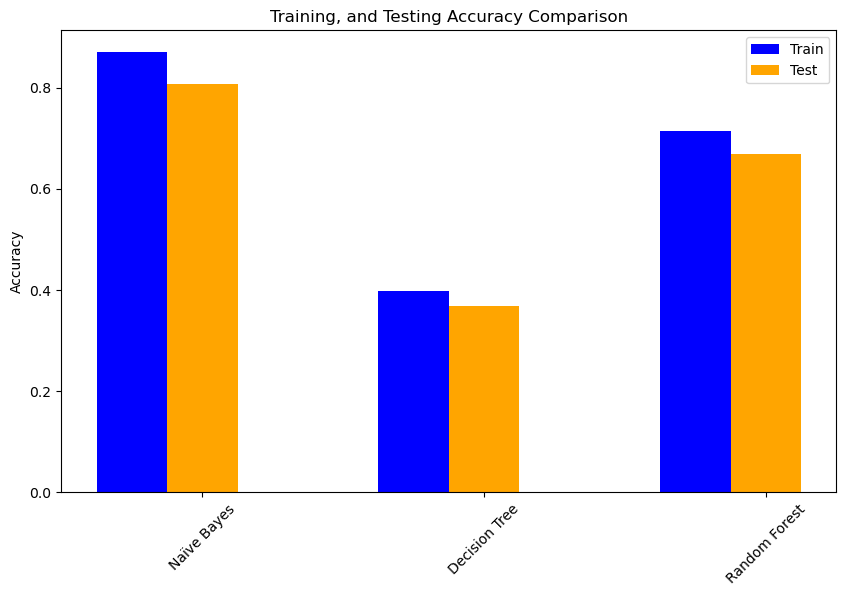

In [31]:
plt.figure(figsize=(10, 6))

bar_width = 0.25
models_list = list(models.keys())

# Training accuracy
train_acc_values = [train_accuracies[model] for model in models_list]
plt.bar(np.arange(len(models_list)), train_acc_values, bar_width, label='Train', color='blue')

# Testing accuracy
test_acc_values = [accuracies[model] for model in models_list]
plt.bar(np.arange(len(models_list)) + bar_width, test_acc_values, bar_width, label='Test', color='orange')

# Labels & Formatting
plt.xticks(np.arange(len(models_list)) + bar_width, models_list, rotation=45)
plt.ylabel("Accuracy")
plt.title("Training, and Testing Accuracy Comparison")
plt.legend()
plt.show()


In [32]:
# Identify and save the best model
best_model = max(accuracies, key=accuracies.get)
best_model_instance = models[best_model]
model_filename = f"{best_model.lower().replace(' ', '_')}_model.pkl"
joblib.dump(best_model_instance, model_filename)
print(f"\n{best_model} model saved successfully as {model_filename}.")


Naïve Bayes model saved successfully as naïve_bayes_model.pkl.


In [33]:
# Save the trained TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("TF-IDF Vectorizer saved successfully.")

TF-IDF Vectorizer saved successfully.


In [34]:
# Load the best-selected model for prediction
loaded_model = joblib.load(model_filename)

In [35]:
#  FEATURE IMPORTANCE ANALYSIS (Naïve Bayes)

if isinstance(loaded_model, MultinomialNB):
    feature_names = vectorizer.get_feature_names_out()
    log_probs = loaded_model.feature_log_prob_

    genre_words = pd.DataFrame(log_probs, columns=feature_names, index=loaded_model.classes_)

    top_n = 100  # Number of top words per genre
    for genre in loaded_model.classes_:
        print(f"\nTop {top_n} Words for Genre: {genre}")
        print(genre_words.loc[genre].nlargest(top_n))


Top 100 Words for Genre: Fantasy
magic       -5.722569
power       -5.922902
king        -6.105778
dragon      -6.132555
land        -6.140793
               ...   
discovers   -7.126376
son         -7.132727
york        -7.139375
forest      -7.139973
ally        -7.141930
Name: Fantasy, Length: 100, dtype: float64

Top 100 Words for Genre: Fiction
child          -6.507920
tale           -6.571306
writer         -6.590335
wife           -6.599025
character      -6.645460
                  ...   
bestselling    -7.361725
relationship   -7.366474
rich           -7.367618
childhood      -7.369433
behind         -7.369441
Name: Fiction, Length: 100, dtype: float64

Top 100 Words for Genre: Historical Fiction


england   -6.195927
king      -6.275491
history   -6.309969
great     -6.454416
girl      -6.459866
             ...   
change    -7.165741
lead      -7.168353
may       -7.170707
north     -7.172053
return    -7.174992
Name: Historical Fiction, Length: 100, dtype: float64

Top 100 Words for Genre: Mystery
murder      -5.440522
killer      -5.514639
detective   -5.547055
case        -5.557148
mystery     -5.679502
               ...   
scene       -7.180126
hidden      -7.180963
left        -7.183701
partner     -7.187446
called      -7.188274
Name: Mystery, Length: 100, dtype: float64

Top 100 Words for Genre: Nonfiction
account   -6.412897
child     -6.426803
human     -6.449093
memoir    -6.474282
history   -6.496153
             ...   
nation    -7.298134
success   -7.298690
faith     -7.299177
reading   -7.299961
modern    -7.300069
Name: Nonfiction, Length: 100, dtype: float64

Top 100 Words for Genre: Romance
never       -5.809675
heart       -5.953493
ever        -6.145558
coul

In [36]:
# Split training data into train and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [37]:
# Evaluate Training Accuracy
train_acc = accuracy_score(y_train_final, best_model_instance.predict(X_train_final))
print(f"\nTraining Accuracy: {train_acc:.4f}")


Training Accuracy: 0.8706


In [38]:
# Evaluate Validation Accuracy
val_acc = accuracy_score(y_val, best_model_instance.predict(X_val))
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.8677


In [39]:
# Evaluate Testing Accuracy
test_acc = accuracy_score(y_test, best_model_instance.predict(X_test))
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8074


In [40]:
# Cross-validation using 5 folds
cv_scores = cross_val_score(best_model_instance, X_train, y_train, cv=5, scoring="accuracy")
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")


Cross-Validation Scores: [0.80236305 0.81686359 0.81378693 0.81110116 0.80734109]
Mean Cross-Validation Accuracy: 0.8103


In [41]:
"""# Function to predict genre
def predict_genre():
    description = text_entry.get("1.0", tk.END).strip()
    if not description:
        messagebox.showwarning("Input Error", "Please enter a book description!")
        return
    
    processed_description = preprocess_text(description, custom_stopwords)
    new_text_tfidf = vectorizer.transform([processed_description])
    predicted_genre = loaded_model.predict(new_text_tfidf)[0]
    
    confidence = None
    if hasattr(loaded_model, "predict_proba"):
        confidence = max(loaded_model.predict_proba(new_text_tfidf)[0]) * 100
    
    result_text = f"Predicted Genre: {predicted_genre}"
    if confidence:
        result_text += f"\nConfidence: {confidence:.2f}%"
    
    messagebox.showinfo("Prediction Result", result_text)"""

'# Function to predict genre\ndef predict_genre():\n    description = text_entry.get("1.0", tk.END).strip()\n    if not description:\n        messagebox.showwarning("Input Error", "Please enter a book description!")\n        return\n    \n    processed_description = preprocess_text(description, custom_stopwords)\n    new_text_tfidf = vectorizer.transform([processed_description])\n    predicted_genre = loaded_model.predict(new_text_tfidf)[0]\n    \n    confidence = None\n    if hasattr(loaded_model, "predict_proba"):\n        confidence = max(loaded_model.predict_proba(new_text_tfidf)[0]) * 100\n    \n    result_text = f"Predicted Genre: {predicted_genre}"\n    if confidence:\n        result_text += f"\nConfidence: {confidence:.2f}%"\n    \n    messagebox.showinfo("Prediction Result", result_text)'

In [42]:
def recommend_books_by_genre(genre, df, n=5):
    filtered = df[df['genres'].str.contains(genre, case=False, na=False)]
    if filtered.empty:
        return ["No recommendations found."]
    recommendations = filtered.sample(n=min(n, len(filtered)))
    return recommendations['title'].tolist()  # instead of 'description'


In [43]:
"""# Recommend books based on predicted genre
def recommend_books_by_genre(genre, df, n=5):
    filtered = df[df['genres'].str.contains(genre, case=False, na=False)]
    if filtered.empty:
        return ["No recommendations found for this genre."]
    recommendations = filtered.sample(n=min(n, len(filtered)))
    return recommendations['description'].tolist()"""


'# Recommend books based on predicted genre\ndef recommend_books_by_genre(genre, df, n=5):\n    filtered = df[df[\'genres\'].str.contains(genre, case=False, na=False)]\n    if filtered.empty:\n        return ["No recommendations found for this genre."]\n    recommendations = filtered.sample(n=min(n, len(filtered)))\n    return recommendations[\'description\'].tolist()'

In [44]:
# Function to predict genre and show recommendations
def predict_genre():
    description = text_entry.get("1.0", tk.END).strip()
    if not description:
        messagebox.showwarning("Input Error", "Please enter a book description!")
        return
    
    processed_description = preprocess_text(description, custom_stopwords)
    new_text_tfidf = vectorizer.transform([processed_description])
    predicted_genre = loaded_model.predict(new_text_tfidf)[0]
    
    confidence = None
    if hasattr(loaded_model, "predict_proba"):
        confidence = max(loaded_model.predict_proba(new_text_tfidf)[0]) * 100
    
    # Book recommendations
    recommended_books = recommend_books_by_genre(predicted_genre, df)
    recommendation_text = "\n- " + "\n- ".join(recommended_books)

    result_text = f"Predicted Genre: {predicted_genre}"
    if confidence:
        result_text += f"\nConfidence: {confidence:.2f}%"
    
    result_text += f"\n\nRecommended Books:\n{recommendation_text}"
    
    messagebox.showinfo("Prediction Result", result_text)


In [45]:
# GUI Setup
root = tk.Tk()
root.title("Book Genre Predictor")
root.geometry("500x400")

label = tk.Label(root, text="Enter Book Description:", font=("Arial", 12))
label.pack(pady=10)

text_entry = tk.Text(root, height=10, width=50)
text_entry.pack(pady=10)

predict_button = tk.Button(root, text="Predict Genre", command=predict_genre, font=("Arial", 12))
predict_button.pack(pady=10)

root.mainloop()